# Tangram Analysis: Domain Prediction

## Xenium Breast Cancer, InSitu Replicate 1

https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer


### Import packages

In [3]:
import os,csv,re
import pandas as pd
import numpy as np

import math
from sklearn.cluster import KMeans

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from torch.nn import functional as F

#Read original data and save it to h5ad
import scanpy as sc
from scanpy import read_10x_h5
from scanpy import read_h5ad

import seaborn as sns
from matplotlib.pyplot import figure
import collections, numpy
import tangram as tg

import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel

In [6]:
def make_annData_spatial (adata, spatial, min_cells = 3, filtered = False):
    """ 
    adata: an annData file for the transcriptomics data
    spatial: an pandas dataframe recording the location information for each spot
    """
    if filtered == False:
        adata.obs["select"] = spatial[1]
        adata.obs["x_cord"] = spatial[2]
        adata.obs["y_cord"] = spatial[3]
        adata.obs["x_pixel"] = spatial[4]
        adata.obs["y_pixel"] = spatial[5]
        # Select captured samples
        adata = adata[adata.obs["select"] == 1]
    else:
        spatialsub = spatial[spatial.iloc[:,0] == 1]
        adata.obs = adata.obs.join(spatialsub)
        adata.obs.columns = ['select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel']
    adata.var_names = [i.upper() for i in list(adata.var_names)]
    adata.var["genename"] = adata.var.index.astype("str")
    #
    adata.var_names_make_unique()
    prefilter_genes(adata, min_cells=min_cells) # avoiding all genes are zeros
    prefilter_specialgenes(adata)
    #Normalize and take log for UMI
    #sc.pp.normalize_per_cell(adata)
    #sc.pp.log1p(adata)
    return adata


In [7]:
def prefilter_genes(adata,min_counts=None,max_counts=None,min_cells=10,max_cells=None):
    if min_cells is None and min_counts is None and max_cells is None and max_counts is None:
        raise ValueError('Provide one of min_counts, min_genes, max_counts or max_genes.')
    id_tmp=np.asarray([True]*adata.shape[1],dtype=bool)
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,min_cells=min_cells)[0]) if min_cells is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,max_cells=max_cells)[0]) if max_cells is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,min_counts=min_counts)[0]) if min_counts is not None  else id_tmp
    id_tmp=np.logical_and(id_tmp,sc.pp.filter_genes(adata.X,max_counts=max_counts)[0]) if max_counts is not None  else id_tmp
    adata._inplace_subset_var(id_tmp)
    
    

In [8]:
def prefilter_specialgenes(adata,Gene1Pattern="ERCC",Gene2Pattern="MT-"):
    id_tmp1=np.asarray([not str(name).startswith(Gene1Pattern) for name in adata.var_names],dtype=bool)
    id_tmp2=np.asarray([not str(name).startswith(Gene2Pattern) for name in adata.var_names],dtype=bool)
    id_tmp=np.logical_and(id_tmp1,id_tmp2)
    adata._inplace_subset_var(id_tmp)

### Load Data:

In [9]:
# cells to be filtered out based on total UMI and number of genes expressed
os.chdir("")
lowUMI_cellID = pd.read_csv("cell_ID_toRemove_filtered_25_25.csv",sep=",",na_filter=False,index_col=0)

In [10]:
#Read in gene expression and spatial location
os.chdir("")
data_xenium = read_10x_h5("Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
spatial_full = pd.read_csv("Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv",sep=",",na_filter=False,index_col=0)

meta_data = spatial_full
meta_data

In [ ]:
os.chdir("")
kmeans10_clustering = pd.read_csv("clusters.csv", index_col=0)

In [13]:
spatial_full

x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                      
1         377.663005   843.541888                154                     0   
2         382.078658   858.944818                 64                     0   
3         319.839529   869.196542                 57                     0   
4         259.304707   851.797949                120                     0   
5         370.576291   865.193024                120                     0   
...              ...          ...                ...                   ...   
167778   7455.404785  5115.021094                238                     1   
167779   7483.771045  5111.720703                 80                     0   
167780   7470.119580  5119.350366                406                     0   
167781   7477.704004  5128.963086                120                     0   
167782   7489.376562  5123.402393                393                     0   

         control_codeword_counts  total_counts   cell_area  nucleus_area  
cell_id                                                                   
1                              0           154  110.361875     45.562656  
2                              0            64   87.919219     24.248906  
3                              0            57   52.561875     23.526406  
4                              0           120   75.230312     35.176719  
5                              0           120  180.218594     34.499375  
...                          ...           ...         ...           ...  
167778                         0           239  219.956094     61.412500  
167779                         0            80   38.427969     25.964844  
167780                         0           406  287.690469     86.158125  
167781                         0           120  235.670469     25.016563  
167782                         0           393  269.447344    111.445625  

[167782 rows x 8 columns]

In [14]:
# The pixel size of Xenium 0.2125 microns. 
# Coordinates in microns from cells.csv.gz can be converted to pixel coordinates 
# by dividing by the pixel size. The origin of the coordinate system is the upper left of the TIFF image.


pixel_size = 0.2125

spatial = pd.DataFrame()
spatial['0'] = spatial_full.x_centroid
spatial['1'] = [1] * 167782
spatial['2'] = spatial_full.x_centroid
spatial['3'] = spatial_full.y_centroid 
spatial['4'] = spatial_full.x_centroid / pixel_size
spatial['5'] = spatial_full.y_centroid / pixel_size

b = ['CellID '] * 167782
a = list(range(1,167783))

#spatial.index = [m+str(n) for m,n in zip(b,a)]

spatial.index = spatial.index.astype('str')


spatial = spatial.drop(['0'], axis = 1)
spatial.index.name = '0'
spatial.columns = spatial.columns.astype('int64')
spatial = spatial.astype('int64')
adata.obs_names = spatial.index.astype('str')

In [22]:
TrainDatafull = make_annData_spatial(adata.copy(), spatial, filtered = True)
TrainDatafull.var['genename'] = TrainDatafull.var.gene_ids
TrainDatafull

AnnData object with n_obs × n_vars = 167782 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'

In [25]:
barcodes = kmeans10_clustering.index.astype(str)
data_xenium_clust = TrainDatafull.copy()[TrainDatafull.obs_names.isin(list(barcodes)), :]
data_xenium_clust.obs['clusters'] = kmeans10_clustering['Cluster'].values.astype(str)

data_xenium_clust

AnnData object with n_obs × n_vars = 166313 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'

### Filter out cells with low UMI and low number of genes expressed

In [26]:
# Filter out low UMI (Q1) and cells with low #genes expressed (Q1)
data_xenium_clust.obs_names = data_xenium_clust.obs_names.astype(np.int64) 
data_xenium_filtered = data_xenium_clust.copy()[~data_xenium_clust.obs_names.isin(lowUMI_cellID.x), :]
data_xenium_filtered

View of AnnData object with n_obs × n_vars = 121277 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'

In [27]:
order = ['1', '2', '3', '5', '4', '6', '7', '8', '9', '10']

### Plot all cells after the filltering criteria

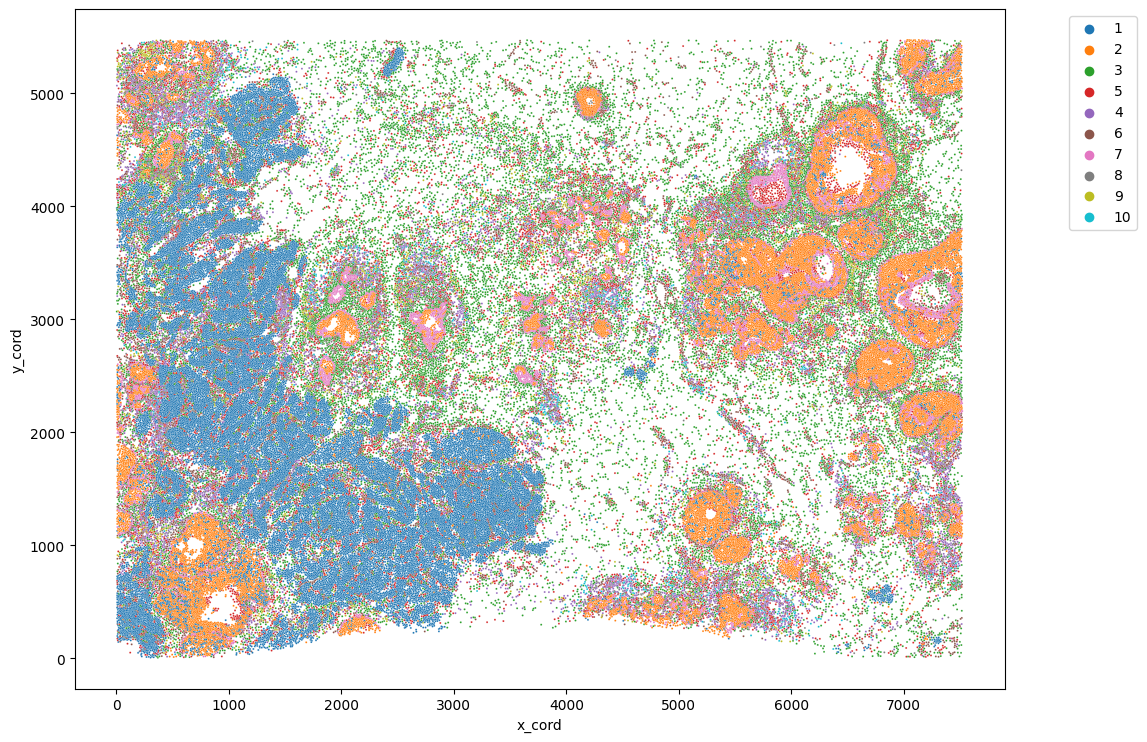

In [28]:
data_filter = data_xenium_filtered.copy()

from matplotlib.pyplot import figure

figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=data_filter.obs, x='x_cord', y='y_cord', hue='clusters',  hue_order=order, s=2)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


In [29]:
data_filter.obs['clusters'] = data_filter.obs['clusters'].astype('category').cat.codes

In [30]:
Rdata_ind, Qdata_ind, _, _ =train_test_split(range(data_filter.shape[0]), data_filter.obs['clusters'], test_size=0.5,random_state=1,stratify=data_filter.obs['clusters'])

Rdata = data_filter[np.sort(Rdata_ind), :]
Qdata = data_filter[np.sort(Qdata_ind), :]
print((Rdata.shape, Qdata.shape))

((60638, 313), (60639, 313))


In [31]:
sc.pp.normalize_total(Rdata)
sc.pp.normalize_total(Qdata)

In [32]:
Rdata

AnnData object with n_obs × n_vars = 60638 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'

In [33]:
Qdata

AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'

In [34]:
Rdata.obs['x'] = Rdata.obs['x_cord']
Rdata.obs['y'] = Rdata.obs['y_cord']

Qdata.obs['x'] = Qdata.obs['x_cord']
Qdata.obs['y'] = Qdata.obs['y_cord']

## Run Tangram domain prediction

In [32]:
## Map Section 2 data into Section 1 data
tg.pp_adatas(Rdata, Qdata, genes=None) #genes = 'None' uses all overlapping genes

INFO:root:313 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:313 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [33]:
my_map = tg.map_cells_to_space(
                   Rdata, 
                   Qdata,         
                   mode='clusters',
                   cluster_label='clusters')


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 313 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.280, KL reg: 0.106
Score: 0.535, KL reg: 0.001
Score: 0.537, KL reg: 0.001
Score: 0.537, KL reg: 0.001
Score: 0.537, KL reg: 0.001
Score: 0.537, KL reg: 0.001
Score: 0.538, KL reg: 0.001
Score: 0.538, KL reg: 0.001
Score: 0.538, KL reg: 0.001
Score: 0.538, KL reg: 0.001


INFO:root:Saving results..


In [35]:
my_map.write_h5ad("")



In [36]:
tg.project_cell_annotations(my_map, Qdata, annotation='clusters')
annotation_list = list(pd.unique(Rdata.obs['clusters']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [37]:
Qdata.obsm['tangram_ct_pred_array'] = np.array(Qdata.obsm['tangram_ct_pred'])
Qdata.obsm['tangram_ct_pred_array'].shape

(60639, 10)

In [38]:
Qdata.obsm['tangram_ct_pred']

0             3             2             5             4  \
0                                                                              
1       3.215510e-09  1.270174e-08  2.131041e-08  1.843036e-04  5.727732e-08   
5       5.718549e-06  3.137455e-08  2.487632e-06  9.386388e-08  2.037200e-04   
7       4.383537e-05  1.107324e-07  1.867973e-05  3.532495e-07  3.864756e-06   
8       1.410185e-08  1.391031e-08  3.878259e-09  1.561336e-08  8.474166e-08   
9       1.891694e-08  6.199431e-08  1.750102e-08  4.565986e-05  7.744583e-08   
...              ...           ...           ...           ...           ...   
167776  7.491837e-07  1.276154e-06  8.168647e-05  1.565470e-05  5.954312e-07   
167778  2.818492e-07  3.174175e-08  8.134305e-05  2.489264e-05  2.187689e-07   
167780  5.549300e-06  6.693125e-08  8.652522e-05  3.407366e-08  9.850777e-08   
167781  1.655688e-06  5.490582e-08  9.760143e-05  1.431273e-07  4.058767e-07   
167782  9.975096e-06  3.795726e-07  7.816347e-05  1.647317e-07  1.351735e-07   

                   6             7             8             9             1  
0                                                                             
1       1.345160e-08  6.270200e-09  1.452896e-08  2.318149e-08  1.611138e-07  
5       3.327271e-06  2.846714e-07  3.717934e-06  1.091261e-05  1.467260e-07  
7       5.789418e-08  5.675590e-08  9.885973e-06  6.566206e-08  1.491777e-07  
8       6.925462e-09  1.775977e-08  5.575285e-04  2.500248e-07  3.671268e-08  
9       2.151277e-08  5.788365e-08  6.756329e-07  5.071714e-04  3.127261e-08  
...              ...           ...           ...           ...           ...  
167776  4.532690e-07  3.768300e-07  4.045743e-07  4.726589e-06  2.671512e-07  
167778  1.156470e-07  1.701986e-07  7.743089e-07  5.050431e-07  6.955739e-07  
167780  9.830190e-08  5.806726e-08  1.232096e-07  1.745678e-07  5.265834e-08  
167781  3.052463e-07  1.915114e-07  1.329017e-07  3.635732e-07  5.872955e-08  
167782  1.315879e-07  5.402006e-08  9.696943e-07  2.861226e-07  1.003093e-07  

[60639 rows x 10 columns]

In [39]:
domain_predict = np.zeros(Qdata.obs.shape[0])
for i in range(Qdata.obsm['tangram_ct_pred_array'].shape[0]):
    maxIndex = np.argmax(Qdata.obsm['tangram_ct_pred_array'][i]) 
    cluster = Qdata.obsm['tangram_ct_pred'].columns[maxIndex]
    domain_predict[i] = cluster 

domain_predict = domain_predict.astype('int64')

In [40]:
Qdata.obs['pred_domain'] = domain_predict

In [41]:
domain_predict

array([5, 4, 0, ..., 2, 2, 2])

In [42]:
data_xenium_filtered.obs['clusters'] = data_xenium_filtered.obs['clusters'].astype('category')
d = dict(enumerate(data_xenium_filtered.obs['clusters'].cat.categories))

In [43]:
d

{0: '1',
 1: '10',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [44]:
Qdata.obs['clusters_int'] = Qdata.obs['clusters'].astype('int64')
Qdata.obs['clusters_int'].map(d)

0
1         5
5         4
7         1
8         8
9         9
         ..
167776    2
167778    2
167780    2
167781    2
167782    2
Name: clusters_int, Length: 60639, dtype: object

In [45]:
Qdata.obs['pred_domain'].map(d)

0
1         5
5         4
7         1
8         8
9         9
         ..
167776    2
167778    2
167780    2
167781    2
167782    2
Name: pred_domain, Length: 60639, dtype: object

In [46]:
Qdata.obs['clusters_true'] = Qdata.obs['clusters_int'].map(d)
Qdata.obs['pred_layer'] = Qdata.obs['pred_domain'].map(d)

In [48]:
np.sum(Qdata.obs['clusters_true'].values == Qdata.obs['pred_layer'].values)/Qdata.shape[0]

0.884100991111331

In [49]:
collections.Counter(Qdata.obs['pred_layer'].values)

Counter({'5': 5795,
         '4': 4520,
         '1': 15103,
         '8': 3250,
         '9': 2246,
         '6': 4492,
         '3': 8369,
         '2': 10431,
         '7': 4536,
         '10': 1897})

In [50]:
collections.Counter(Qdata.obs['clusters_true'].values)

Counter({'5': 5758,
         '4': 4068,
         '1': 16817,
         '8': 2460,
         '9': 1731,
         '6': 3717,
         '3': 11185,
         '2': 10341,
         '7': 3675,
         '10': 887})

In [51]:
order = ['1', '2', '3', '5', '4', '6', '7', '8', '9', '10']

In [52]:
Qdata

AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'clusters', 'x', 'y', 'pred_domain', 'clusters_int', 'clusters_true', 'pred_layer'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    obsm: 'tangram_ct_pred', 'tangram_ct_pred_array'

## Plot true querry data domains:

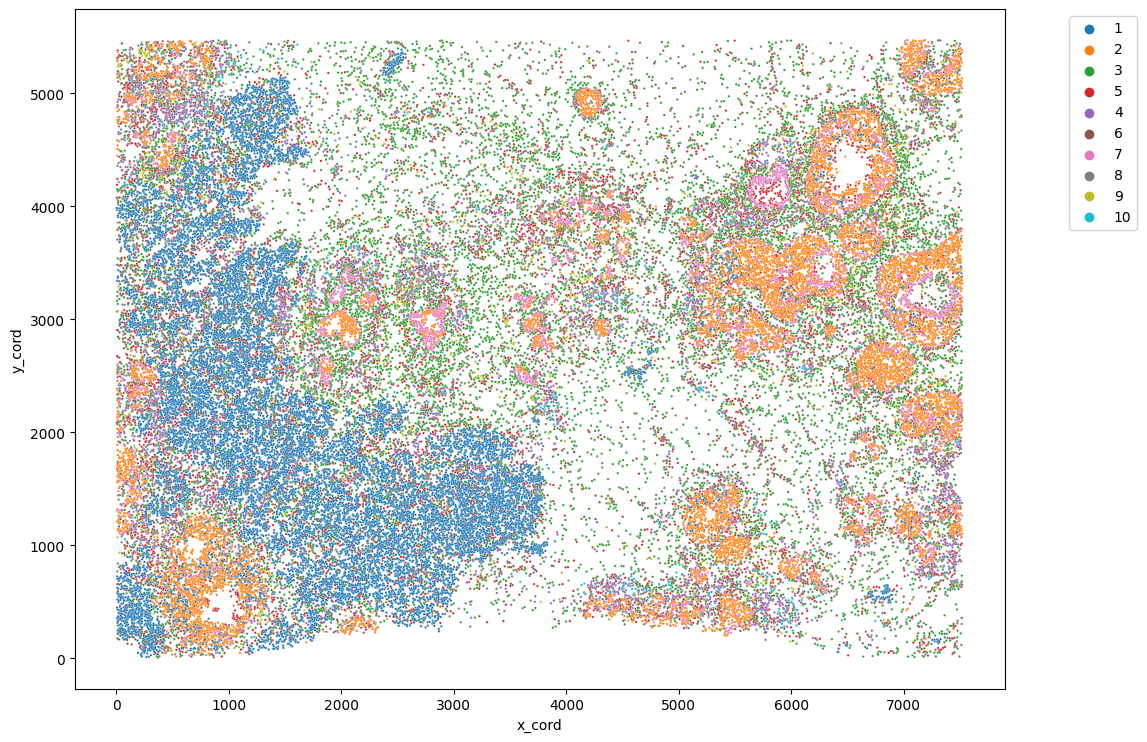

In [53]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=Qdata.obs, x='x_cord', y='y_cord',  hue_order=order, hue='clusters_true', s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


## Plot predicted querry data domains:

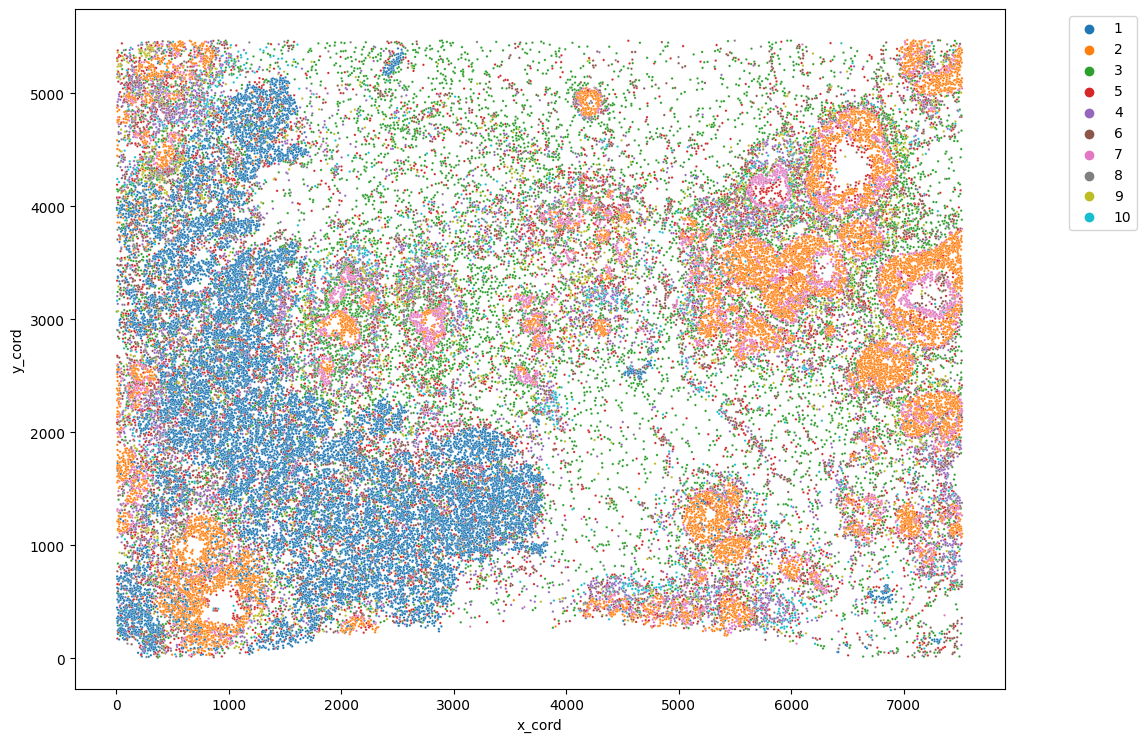

In [54]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=Qdata.obs, x='x_cord', y='y_cord',  hue_order=order,hue='pred_layer', s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


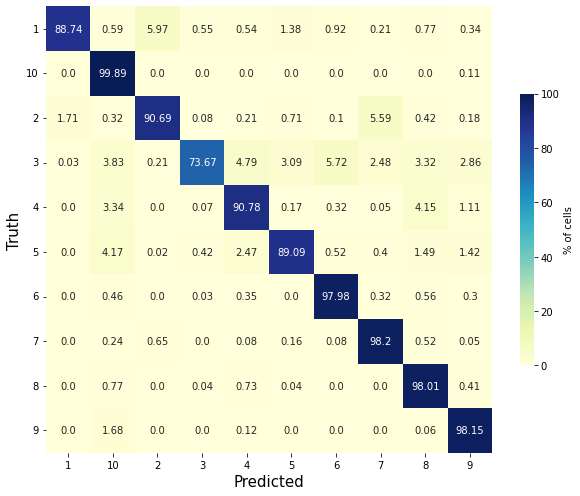

In [55]:

type_pred = np.array(Qdata.obs['pred_layer'].values)
type_true = np.array(Qdata.obs['clusters_true'].values)

contigency = pd.crosstab(type_true, type_pred)


for i in range(contigency.shape[0]):
    contigency.iloc[i,:] = contigency.iloc[i,:]/np.sum(contigency, axis=1)[i] * 100

fig = plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

annot_m = np.empty(contigency.shape,dtype='<U16')
for i in range(contigency.shape[0]):
    for j in range(contigency.shape[0]):
        annot_m[i,j] = np.round(contigency.iloc[i,j], 2)

res = sns.heatmap(contigency, annot=annot_m, fmt="", cmap="YlGnBu", vmin=0.0, vmax=100, cbar_kws={'label': '% of cells', "shrink": 0.5}).set(ylabel="Truth", xlabel="Predicted")
cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(10)
# cbar = res.collections[0].colorbar
# cbar.set_label('Label for colour bar axis', labelpad=40)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Truth", fontsize=15)
# plt.title('How to plot a coningency table with python \n using matplotlib and seaborn ?',fontsize=12)

plt.xticks([i+0.5 for i in range(contigency.shape[0])], list(contigency.index))
plt.xticks(rotation=0)

plt.yticks([i+0.5 for i in range(contigency.shape[1])], list(contigency.index))
plt.yticks(rotation=0)

plt.yticks(rotation=0)

os.chdir("/Users/ameliaschroeder/Box/Amelia_Biostatistician/Celery/Output_Celery/Xenium_BreastCancer/Figures_Final/Domain")
plt.savefig('xenium_rep1_scheme2_tangram_domain_contigency.png', dpi=100)


plt.show()



